In [1]:
import pandas as pd
import ruamel.yaml as yaml
import os
import numpy as np
import sys
import altair as alt
alt.themes.enable('opaque')

# ## Change to Root

# In[15]:


NO_CONFIG_ERR_MSG = """No config file found. Root directory is determined by presence of "config.yaml" file."""        

original_wd = os.getcwd()

# Number of times to move back in directory
num_retries = 10
for x in range(0, num_retries):
    # try to load config file    
    try:
        with open("config.yaml", 'r') as stream:
            cfg = yaml.safe_load(stream)
    # If not found move back one directory level
    except FileNotFoundError:
        os.chdir('../')
        # If reached the max number of directory levels change to original wd and print error msg
        if x+1 == num_retries:
            os.chdir(original_wd)
            print(NO_CONFIG_ERR_MSG)
            
# Add directory to PATH
path = os.getcwd()

if path not in sys.path:
    sys.path.append(path)

In [2]:
clustering_results = pd.read_csv('results/clustering_results.csv')
grid_search_results = pd.read_csv('results/grid_search_results.csv')
tsne_results = pd.read_csv('results/tsne_results.csv')
component_quality_results = pd.read_csv('results/component_quality.csv')

## Fix Redundant naming of clustering algorithms
clustering_alg_map = {
    'K_Means':'K-Means',
     'EM':'EM',
     'GMM':'EM',
     'Kmeans':'K-Means',
}

clustering_results['Clustering_Algorithm'] = clustering_results['Clustering_Algorithm'].map(clustering_alg_map)
clustering_results['Clustering_Algorithm'].value_counts()

K-Means    270
EM         270
Name: Clustering_Algorithm, dtype: int64

In [3]:
categories = [col for col in clustering_results.columns.values.tolist()
                   if (col != 'N_Clusters') & (col != 'Value')
                   ]
for col in categories:
    print(col)
    display(clustering_results[col].unique())

Clustering_Algorithm


array(['K-Means', 'EM'], dtype=object)

Dataset


array(['Madelon', 'Cars'], dtype=object)

Metric


array(['SSE', 'log-likelihood', 'Accuracy', 'Mutual_Information'],
      dtype=object)

Data_Perspective


array(['BASE', 'ICA', 'PCA', 'RP', 'RF'], dtype=object)

#

## An Approach to Analysis

###### Component Analysis
* Evaluate along reconstruction error and specific valuations (adj mutual info, explained variance, etc)


###### Clustering
1) Start with the baseline

2) Under BASE data, evaluate clusters
    
    * Across N for K Means
        * SSE 
    * Across N for EM
        * Log Likelihood
        
3) Relationship to Target Class
    * Evaluate Mutual Information
    
    * Evaluate Accuracy
    
4) In Later Analysis return and do the same for PCA, ICA, RP and possibly RF    

## Component Quality

In [4]:
component_quality_results.head()

Data_Perspective Dataset  N_Components                           Metric  \
0              ICA    Cars             2  Avg_Component_Absolute_Kurtosis   
1              ICA    Cars             4  Avg_Component_Absolute_Kurtosis   
2              ICA    Cars             6  Avg_Component_Absolute_Kurtosis   
3              ICA    Cars             8  Avg_Component_Absolute_Kurtosis   
4              ICA    Cars            10  Avg_Component_Absolute_Kurtosis   

      Value  
0  1.200207  
1  1.255312  
2  1.500869  
3  1.366870  
4  1.541869

Reconstruction Error

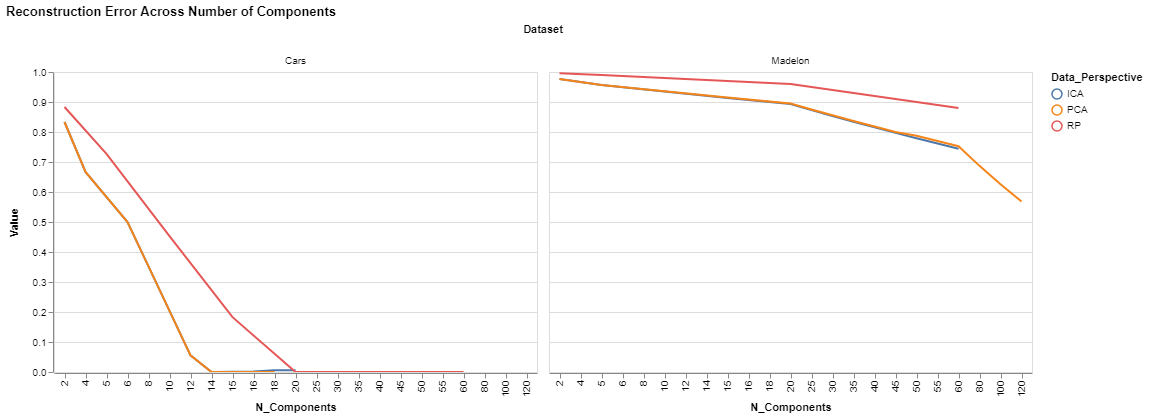

In [12]:
# alt.Chart(component_quality_results).mark_line().encode(
#     x='N_Components:O',
#     y='Value:Q',
#     color='Dataset:N',
#     column='Data_Perspective:N'
# ).transform_filter(
#     alt.datum.Metric == 'Reconstruction_Error'
# ).interactive()

alt.Chart(component_quality_results).mark_line().encode(
    x='N_Components:O',
    y='Value:Q',
    color='Data_Perspective:N',
    column='Dataset:N'
).transform_filter(
    alt.datum.Metric == 'Reconstruction_Error'
).properties(
    title='Reconstruction Error Across Number of Components'
).interactive()

#### Component Quality

In [6]:
metric_dict = {
    'ICA':'Avg_Component_Absolute_Kurtosis',
    'PCA':'Explained_Variance',
    'RP':'Projected_Pairwise_Distance_10_Trial_Correlation_Avg'
}

In [7]:
component_quality_charts = []
for alg, metric in metric_dict.items():
    chart = alt.Chart(component_quality_results).mark_line().encode(
        x='N_Components:Q',
        y='Value:Q',
        color='Dataset:N',
    ).transform_filter(
        (alt.datum.Metric == metric)
        & (alt.datum.Data_Perspective == alg)
    ).properties(
        title=f'Component Quality for {alg} measured by {metric}'
    )
#     display(chart)
    component_quality_charts.append(chart)

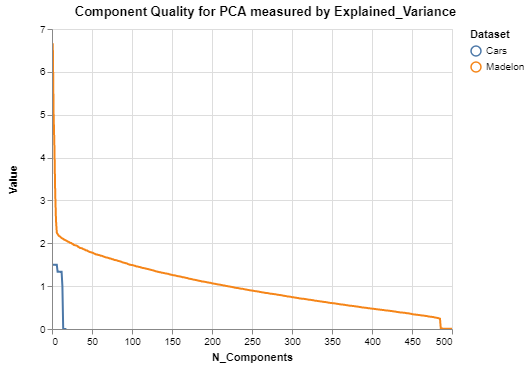

In [11]:
component_quality_charts[1].interactive()

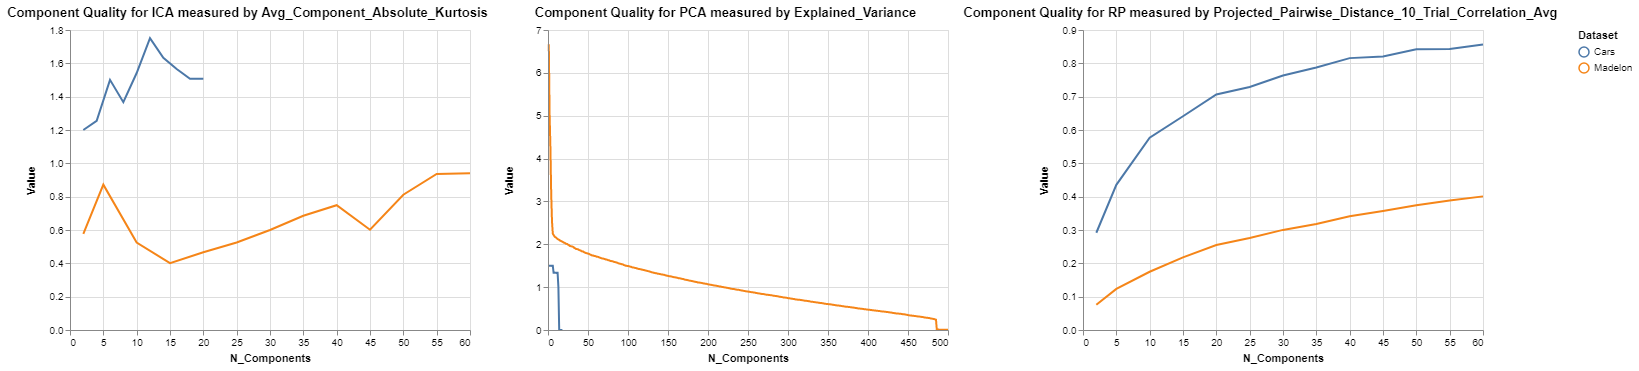

In [9]:
alt.hconcat(component_quality_charts[0], component_quality_charts[1], component_quality_charts[2])

## Variation of N across K Means and EM

In [47]:
clustering_results.Clustering_Algorithm.unique()

array(['K-Means', 'EM'], dtype=object)

In [48]:
representation = 'BASE'
algorithms = ['K_Means', 'EM']
datasets = ['Madelon', 'Cars']
clustering_quality_metrics = ['SSE', 'log-likelihood']
classifcation_metrics = ['Accuracy', 'Mutual Information']
clustering_results.query('Data_Perspective == @representation').head()

Clustering_Algorithm  N_Clusters  Dataset Metric          Value  \
0              K-Means           2  Madelon    SSE  901709.421231   
1              K-Means           5  Madelon    SSE  891880.862735   
2              K-Means          10  Madelon    SSE  885554.749546   
3              K-Means          15  Madelon    SSE  881723.610571   
4              K-Means          20  Madelon    SSE  878695.336027   

  Data_Perspective  
0             BASE  
1             BASE  
2             BASE  
3             BASE  
4             BASE

In [52]:
# clustering_chart = alt.Chart(clustering_results).mark_bar().encode(
#         x=alt.X('N_Clusters:Q'),
#         y=alt.Y('Value:Q'),
#     column='N_Clusters',
#     ).properties(
#         title='Clustering Metric Evaluations',
#         width=300,
#         height=150,
# ).transform_filter(
#         (alt.datum.Data_Perspective == representation)
#     & (alt.datum.Metric == 'SSE')

# )
# clustering_chart    

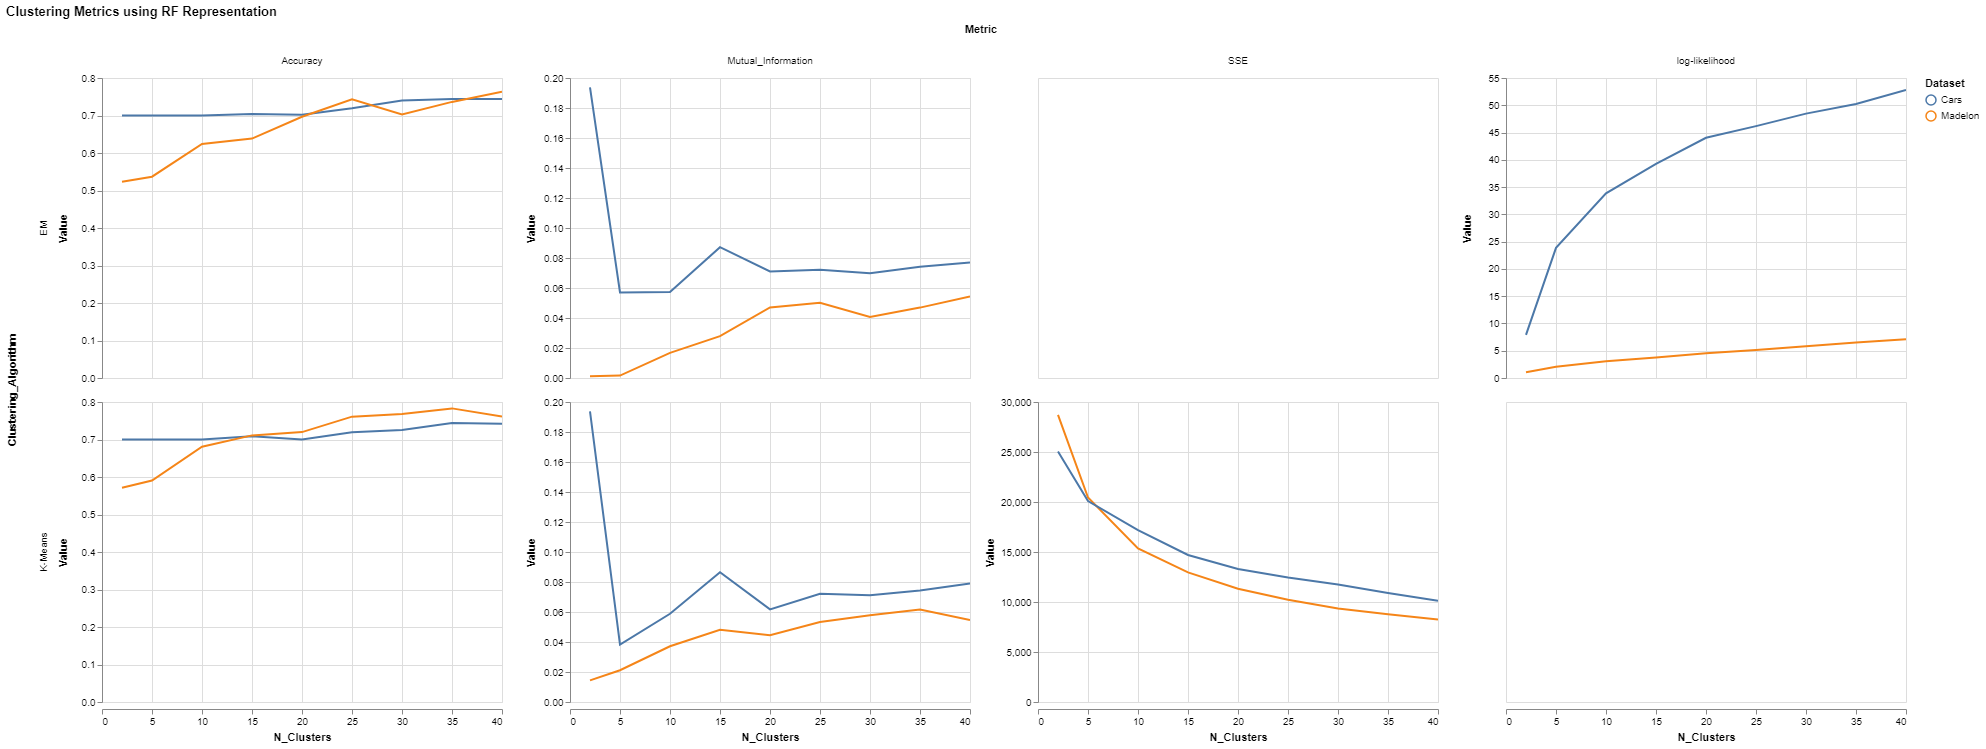

In [64]:
clustering_chart = alt.Chart(clustering_results).mark_line().encode(
            x=alt.X('N_Clusters:Q'),
            y=alt.Y('Value:Q'),
            color='Dataset'
        ).facet(
            title=f'Clustering Metrics using {representation} Representation',
            column='Metric',
            row='Clustering_Algorithm',
        ).resolve_scale(
            y='independent'
        ).transform_filter(
            (alt.datum.Data_Perspective == representation)
        ).interactive()
clustering_chart

In [67]:
# clustering_metric_charts_collection = []
# for dataset in datasets:
#     clustering_chart = alt.Chart(clustering_results).mark_bar().encode(
#         x=alt.X('N_Clusters:Q'),
#         y=alt.Y('Value:Q'),
#         color='Clustering_Algorithm'
#     ).properties(
#         title='Clustering Metric Evaluations',
#         width=300,
#         height=150,
#     ).facet(
#         title=f'Clustering Metrics for {dataset} dataset',
#         column='Metric',
#         row='Clustering_Algorithm',
#     ).resolve_scale(
#         y='independent'
#     ).transform_filter(
#         (alt.datum.Data_Perspective == representation)
#         &
#         (alt.datum.Dataset == dataset)
#     )
#     #display(clustering_chart)
#     clustering_metric_charts_collection.append(clustering_chart)
    
# alt.vconcat(*clustering_metric_charts_collection)

def clustering_bar_metrics(clustering_metrics_df, datasets_lst, data_representation):
    """Given a tidy clustering metrics df and a list of datasets to subset and aggreagte by,
    as well as a data reprentation filter (e.g. 'PCA', 'ICA', etc) generate a compound chart
    across metrics and number of clusters
    """
    
    clustering_metric_charts_collection = []
    for dataset in datasets_lst:
        clustering_chart = alt.Chart(clustering_results).mark_bar().encode(
            x=alt.X('N_Clusters:Q'),
            y=alt.Y('Value:Q'),
            color='Clustering_Algorithm'
        ).properties(
            title='Clustering Metric Evaluations',
            width=300,
            height=150,
        ).facet(
            title=f'Clustering Metrics for {dataset} dataset',
            column='Metric',
            row='Clustering_Algorithm',
        ).resolve_scale(
            y='independent'
        ).transform_filter(
            (alt.datum.Data_Perspective == representation)
            &
            (alt.datum.Dataset == dataset)
        )
        #display(clustering_chart)
        clustering_metric_charts_collection.append(clustering_chart)
    compound_chart = alt.vconcat(*clustering_metric_charts_collection)
    return compound_chart
        

    
def clustering_line_metrics(clustering_metrics_df, data_representation):
    """Given a tidy clustering metrics df and a list of datasets to subset and aggreagte by,
    as well as a data reprentation filter (e.g. 'PCA', 'ICA', etc) generate a compound chart
    across metrics and number of clusters
    """
    
    clustering_chart = alt.Chart(clustering_metrics_df).mark_line().encode(
        x=alt.X('N_Clusters:Q'),
        y=alt.Y('Value:Q'),
        color='Dataset'
    ).facet(
        title=f'Clustering Metrics using {data_representation} Representation',
        column='Metric',
        row='Clustering_Algorithm',
    ).resolve_scale(
        y='independent'
    ).transform_filter(
        (alt.datum.Data_Perspective == representation)
    ).interactive()
    return clustering_chart

# for representation in clustering_results.Data_Perspective.unique():
#     print(f'\n{representation}\n')
#     display(clustering_line_metrics(clustering_results, representation))
#     print()

#### Visualize Grid Search Data

In [54]:
grid_search_results.Clustering_Algorithm.unique()

array(['GMM', 'Kmeans', 'None'], dtype=object)

Group by N components and get the best test score

In [39]:
query_clustering_data = 1
query_clustering_algorithm = 'GMM'
query_clustering_data_perspective = 'ICA'
query_dataset = 'Cars'
analysis_data = grid_search_results.query('(Data_Perspective == @query_clustering_data_perspective)'
                         '& (Dataset == @query_dataset)'
                         '& (Clustered_Data == @query_clustering_data)')
if query_clustering_data == 1:
    analysis_data = analysis_data.query('Clustering_Algorithm == @query_clustering_algorithm')
analysis_data.groupby(by='N_Components/Clusters/Features').mean()['mean_test_score'].sort_values(ascending=False)

N_Components/Clusters/Features
5     0.700231
2     0.700231
10    0.689931
30    0.653848
35    0.653009
20    0.643692
25    0.633304
15    0.632639
40    0.629456
Name: mean_test_score, dtype: float64

## Visualize t-sne

In [79]:
tsne_results.head()

X          Y  Target Dataset Data_Perspective
0 -31.615511 -25.296206     0.0    cars             BASE
1 -17.212791 -12.543370     0.0    cars             BASE
2 -27.641699 -27.702856     0.0    cars             BASE
3 -19.924063 -29.720591     0.0    cars             BASE
4 -17.961168 -15.166670     0.0    cars             BASE

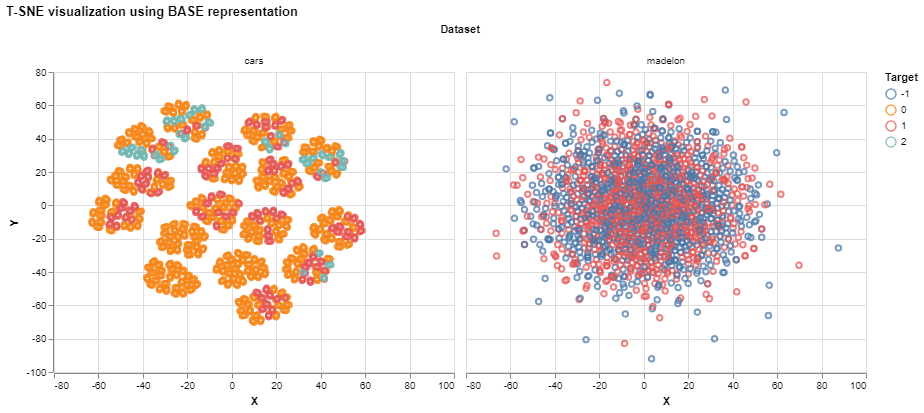

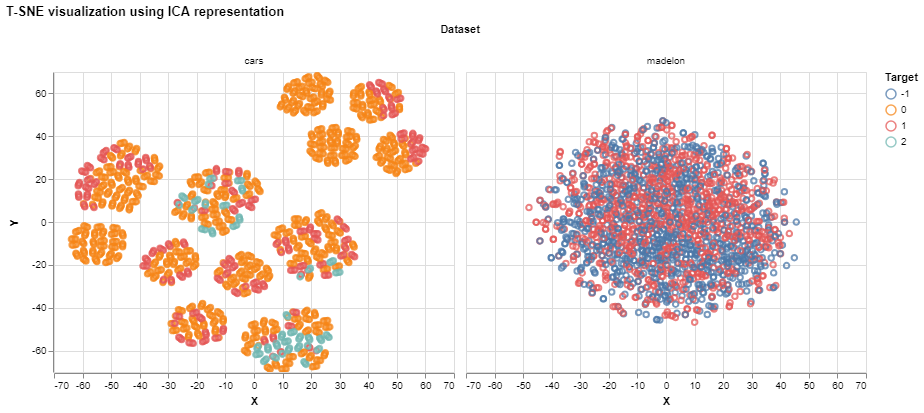

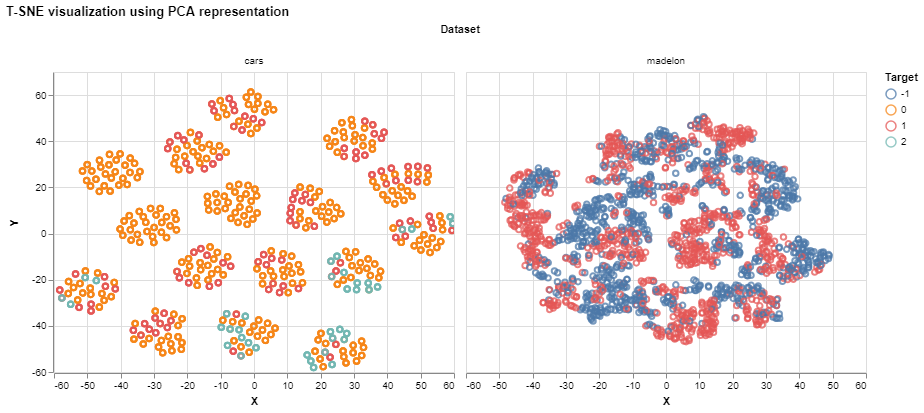

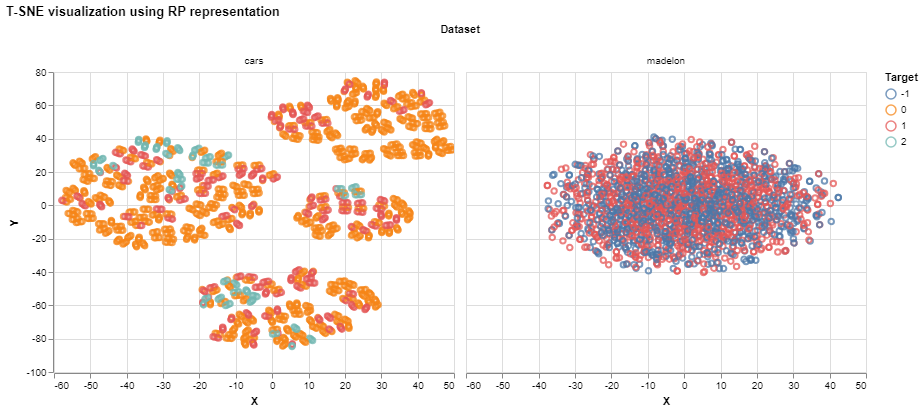

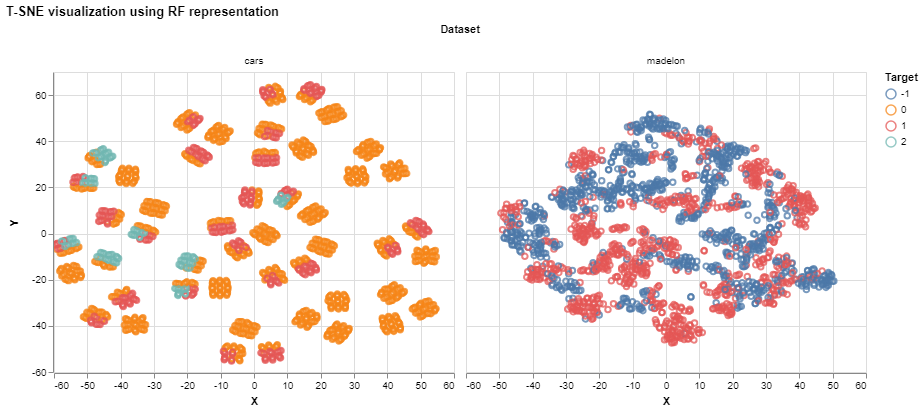

In [89]:
# representation = 'PCA'
# tmp_tsne = tsne_results.query('Data_Perspective == @representation')
# for 
# alt.Chart(tmp_tsne).mark_point(opacity=.75).encode(
#     x='X',
#     y='Y',
#     color='Target:N',
#     column='Dataset'
# )

def plot_tsne(tsne_results, data_representation):
    # Reduce the data so altair can plot
    tmp_tsne = tsne_results.query('Data_Perspective == @data_representation')
    tsne_chart = alt.Chart(tmp_tsne).mark_point(opacity=.75).encode(
        x='X',
        y='Y',
        color='Target:N',
        column='Dataset'
    ).properties(
        title = f'T-SNE visualization using {data_representation} representation',
    ).interactive()
    return tsne_chart
    
for representation in clustering_results.Data_Perspective.unique():
#     print(f'\n{representation}\n')
    display(plot_tsne(tsne_results, representation))
    print()    

## Component analysis for PCA, ICA, 